In [1]:
%matplotlib inline  
# %matplotlib notebook

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stat
import scipy.signal as signal
import scipy.fft
import pywt

plt.rcParams["figure.figsize"] = (20, 5)

In [2]:
# Orientácia akcelerometra na Motorola MotoE6: mobil je prednou kamerou v smere jazdy

# Datasety:  01_L3_Skoda_30T.csv, 02_L9_CKD_T6A5.csv, 03_L4_CKD_T3M.csv, 04_L9_CKD_K2S.csv, 05_X4_BMEZ.csv
DATASET = '01_L3_Skoda_30T.csv'

route = pd.read_csv(DATASET, sep=' ', names=['ax', 'ay', 'az', 'dt'])
with open('metadata.json', 'r') as metadata:
    desc = json.load(metadata)
    
route['t'] = route['dt'].cumsum() / 1000   # Premeň ms na s
route.set_index('t', inplace=True)
route.describe()

,ax,ay,az,dt
count,164837.000000,164837.000000,164837.000000,164837.000000
mean,0.323505,-0.065369,9.538739,4.999964
std,0.215815,0.660484,0.191415,0.583489
min,-2.182000,-1.770000,7.801000,0.000000
25%,0.259000,-0.170000,9.487000,5.000000
50%,0.316000,-0.094000,9.525000,5.000000
75%,0.393000,0.001000,9.573000,5.000000
max,2.825000,1.926000,11.737000,6.000000


In [3]:
# Štatistiská charakteristika
m_ax = np.mean(route['ax'])
m_ay = np.mean(route['ay'])
m_az = np.mean(route['az'])

# Odstráň DC zložku (Bias)
route['ax_c'] = route['ax'] - m_ax
route['ay_c'] = route['ay'] - m_ay
route['az_c'] = route['az'] - m_az

# Pozor: dá sa normalizovať s konštatným priemerom iba ak je senzor nepohyblivý vzhľadom na inerciálnu sustávu
# Extrahovať okno, kde sa nachádza vibrácia a spraviť histogram
print('mean(A):', m_ax, m_ay, m_az)  # polohový vektor
print('stdev(A):', np.std(route['ax']), np.std(route['ay']), np.std(route['az']))
print('skew(A):', stat.skew(route['ax']), stat.skew(route['ay']), stat.skew(route['az']))
print('kurtosis(A):', stat.kurtosis(route['ax']), stat.kurtosis(route['ay']), stat.kurtosis(route['az']))
print('MAD(A):', stat.median_abs_deviation(route['ax']), stat.median_abs_deviation(route['ay']), stat.median_abs_deviation(route['az']))

mean(A): 0.32350548723890865 -0.0653691525567682 9.538739063438426
stdev(A): 0.21581412410994769 0.6604820114198263 0.1914143907709083
skew(A): -0.1544729483056856 0.09975396432201487 0.8811170577367279
kurtosis(A): 9.77566942768099 0.5164818373020199 10.397792665486383
MAD(A): 0.067 0.087 0.04800000000000004


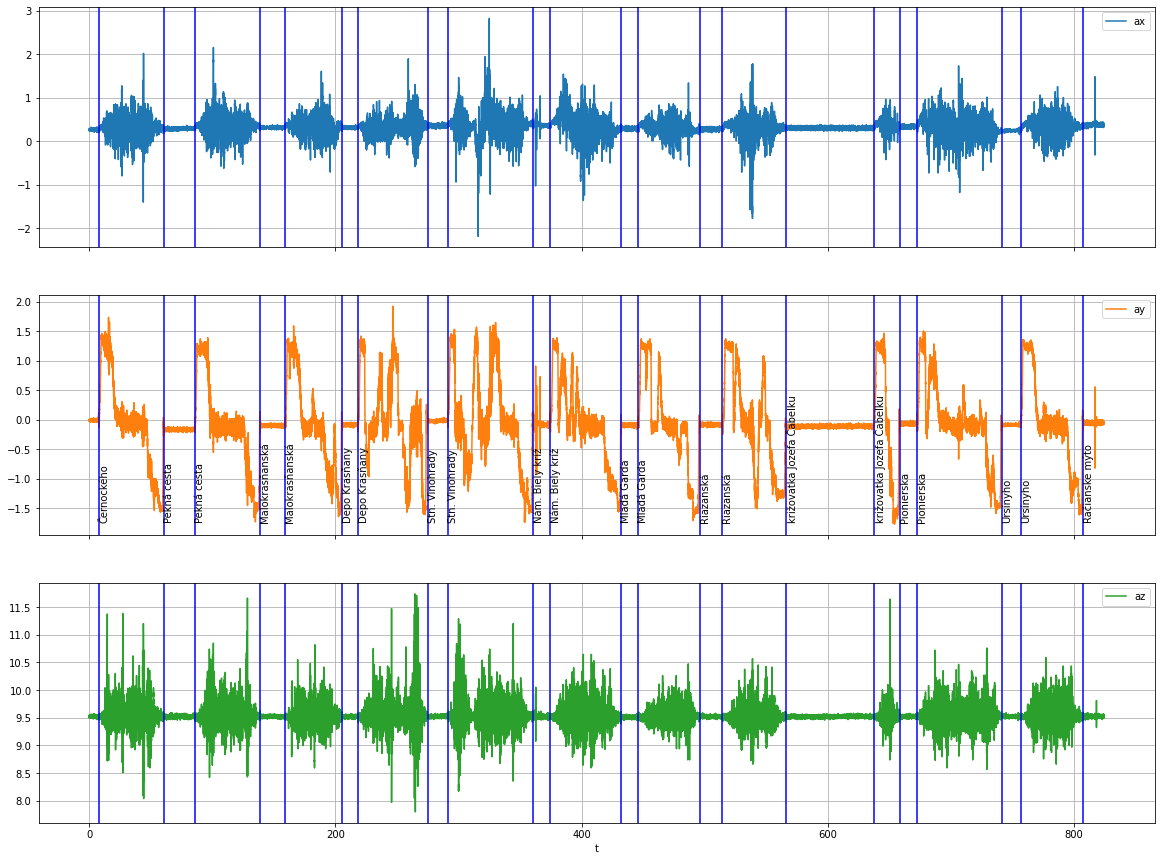

In [4]:
# Graf zložiek vektora akcelerácie (metadáta sa načítajú podľa názvu datasetu)
route_graph = route[['ax', 'ay', 'az']].plot(figsize=(20, 15), subplots=True, grid=True)
for stop in desc[DATASET]['stops']:
    for i in range(3):
        route_graph[i].axvline(stop['s'], color='b')
    route_graph[1].text(stop['s'], -1.7, stop['x'], rotation='vertical')

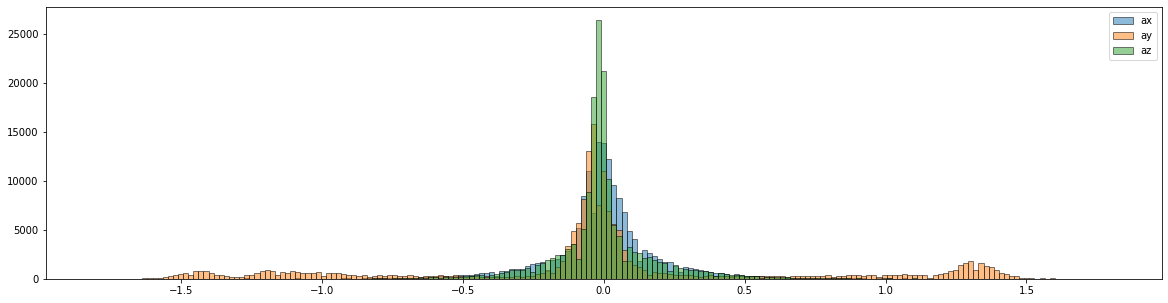

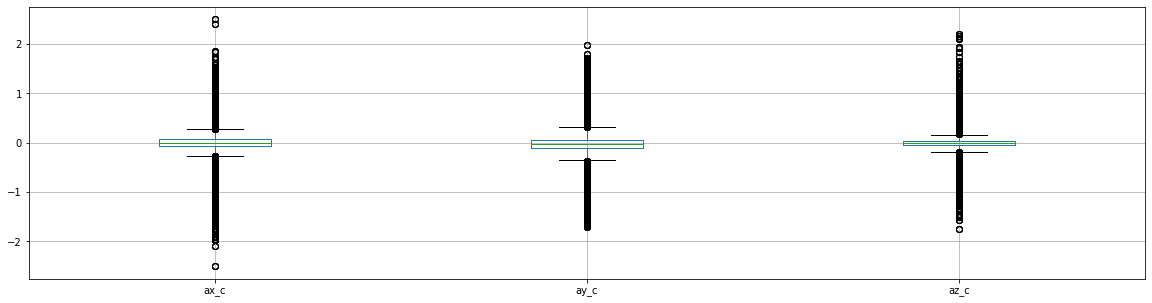

In [5]:
# Histogram
bins = np.linspace(-1.8, 1.8, 200)
plt.hist(route['ax_c'], bins, alpha=0.5, label='ax', edgecolor='k')
plt.hist(route['ay_c'], bins, alpha=0.5, label='ay', edgecolor='k')
plt.hist(route['az_c'], bins, alpha=0.5, label='az', edgecolor='k')
plt.legend(loc='upper right')
plt.show()

# zo špicacosti asi: Laplace distribution
boxplot = route.boxplot(column=['ax_c', 'ay_c', 'az_c'])

array([<AxesSubplot:xlabel='t'>, <AxesSubplot:xlabel='t'>,
       <AxesSubplot:xlabel='t'>, <AxesSubplot:xlabel='t'>], dtype=object)

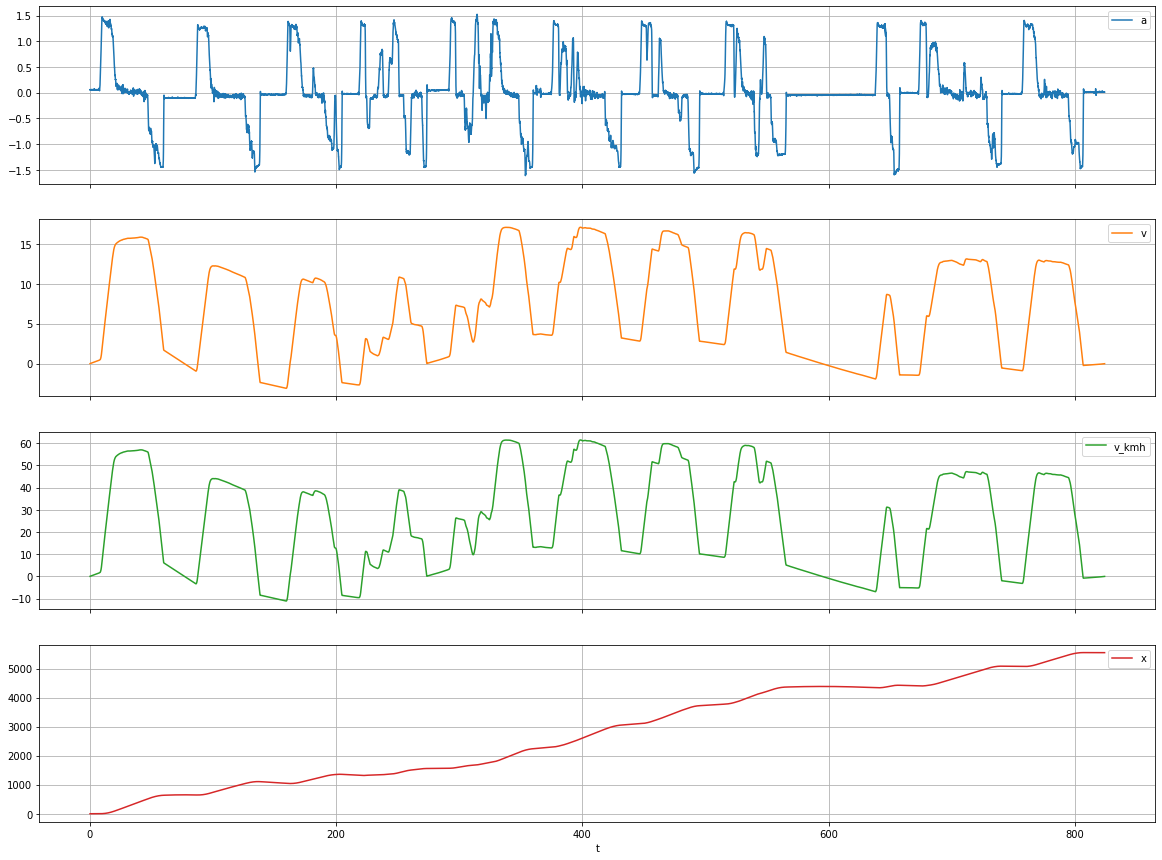

In [6]:
N = 64
kernel = np.ones(N) / N   # Mean filter

dt = route['dt'].values[kernel.size - 1:] / 1000
t = route.index.values[kernel.size - 1:]
a_mean = np.convolve(route['ay_c'].values, kernel, mode='valid')        # Redukuj šum s kernelom

ad = pd.DataFrame({'t': t, 'dt': dt, 'a': a_mean})
ad.set_index('t', inplace=True)

# Priama numerická integrácia na výpočet rýchlosti a polohy z odšumeného signálu
# Nutné uplatniť korekcie napr.: https://www.jvejournals.com/article/16965/pdf

ad['v'] = np.cumsum(ad['a'] * ad['dt'])  # m/s  Rectangular integral
# ad['v'] = np.cumsum(((ad['a'] + ad['a'].shift(-1)) / 2) * ad['dt'])   # Trapezoidal Rule

ad['v_kmh'] = ad['v'] * 3.6
ad['x'] = np.cumsum(ad['v'] * ad['dt'])  # m
ad[['a', 'v', 'v_kmh', 'x']].plot(figsize=(20, 15), subplots=True, grid=True)

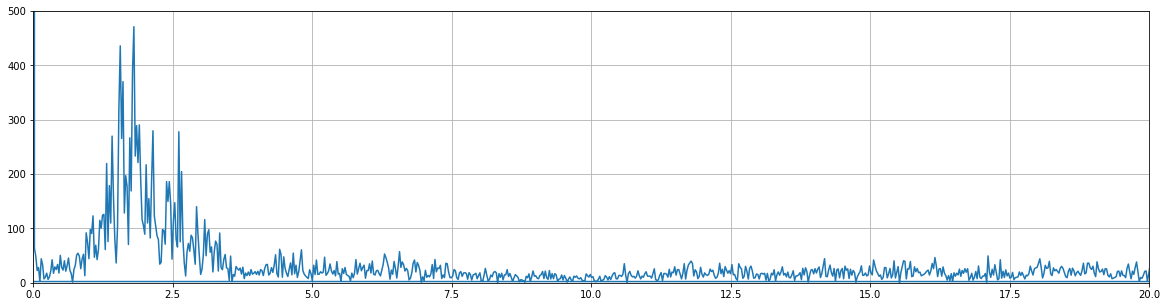

In [7]:
# Zvolené okno zo signálu na frekvenčnú analýzu
X = 2000
N = 8192
x = np.fft.fftfreq(N, 1/200)

route_a = np.absolute(np.fft.fft(route['az'].values[X:X+N]))
plt.plot(x, route_a, label='L3')
plt.xlim(0, 20)
plt.ylim(0, 500)
#plt.yscale('log')
plt.grid()

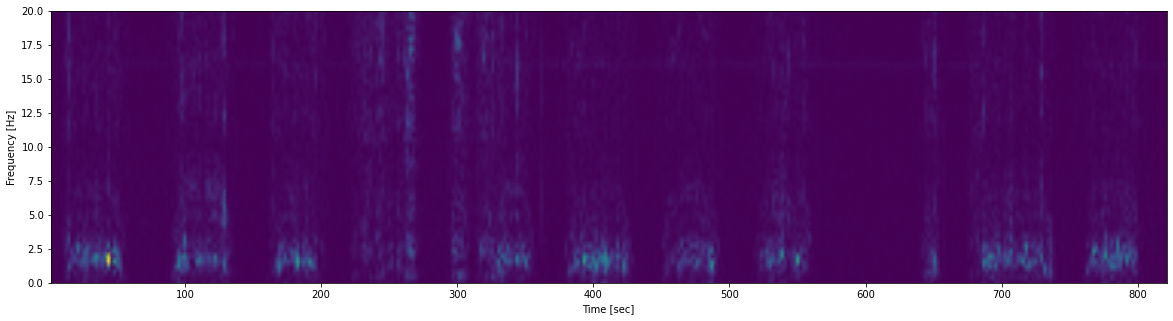

(367,) (257,) (257, 367)


In [8]:
# Spektrálny plot pre všetky okná (Spektrogram)
fs = 200
W = 512
f, t, Sxx = signal.spectrogram(
    route['az_c'], fs,   
    nperseg=W, 
    mode='magnitude', 
    window='tukey', 
    noverlap=W//8,
    scaling='spectrum'  # density
)  #boxcar, psd (g/Hz) magnitude (g)
f_norm = f # np.exp(f)

plt.pcolormesh(t, f_norm, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 20)               # Umelo ohraničené, aby booli viditeľné nízke frekvencie
plt.show()
print(t.shape, f_norm.shape, Sxx.shape)

2.34375

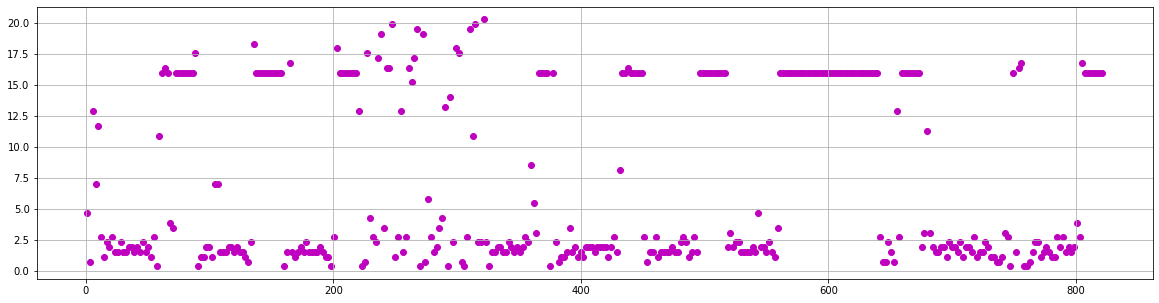

In [9]:
peaks = np.argmax(Sxx, axis=0)
peaks = np.take(f, peaks)
plt.scatter(t, peaks, color='m')
plt.grid()
np.median(peaks)   # Najčastejšia frekvencia v Hz

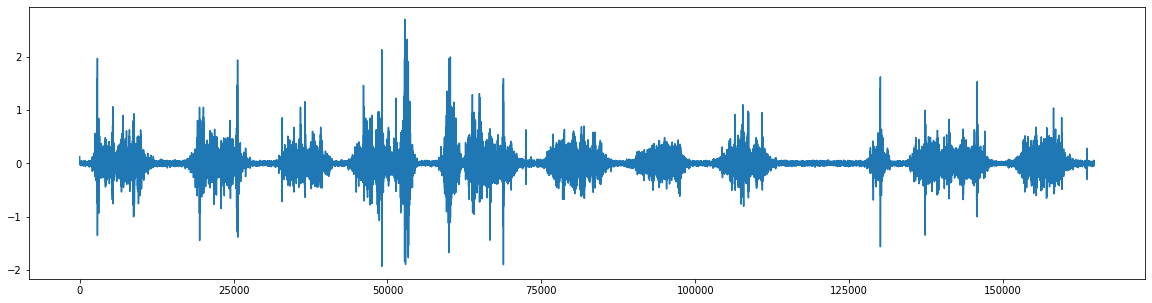

In [10]:
# DC blocking IIR filter: https://ccrma.stanford.edu/~jos/filters/DC_Blocker.html
R = 0.9
x = route['az'].values
y = [x[0]]
for i in range(1, x.size):
    y.append(x[i] - x[i-1] + R*y[i-1])
y = np.array(y[40:])
plt.plot(np.arange(0, y.size), y)
plt.show()

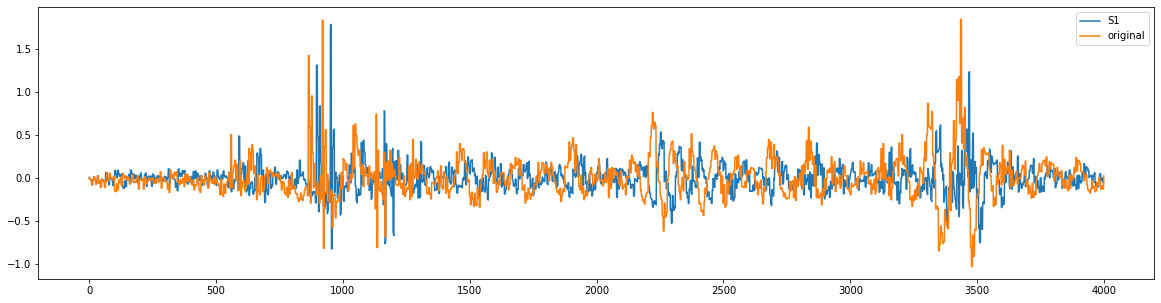

In [11]:
# Peak function S1, S2: https://www.researchgate.net/publication/228853276_Simple_Algorithms_for_Peak_Detection_in_Time-Series
W = 32
x = route['az_c'].values[2000:6000]   # Orezaný počet vzoriek
y = list(x[:W*2])

for i in range(W, x.size - W):
    # l = max(x[i] - x[i-1], x[i] - x[i-2], x[i] - x[i-3], x[i] - x[i-4], x[i] - x[i-5])
    # r = max(x[i] - x[i+1], x[i] - x[i+2], x[i] - x[i+3], x[i] - x[i+4], x[i] - x[i+5])
    l = 0
    r = 0
    for j in range(W):
        l += (x[i] - x[i-j])
        r += (x[i] - x[i+j])
    l /= W
    r /= W
    y.append((l+r) / 2)

t = np.arange(0, len(y))
plt.plot(t, y, label='S1')
plt.plot(t, x, label='original')
plt.legend()
plt.show()

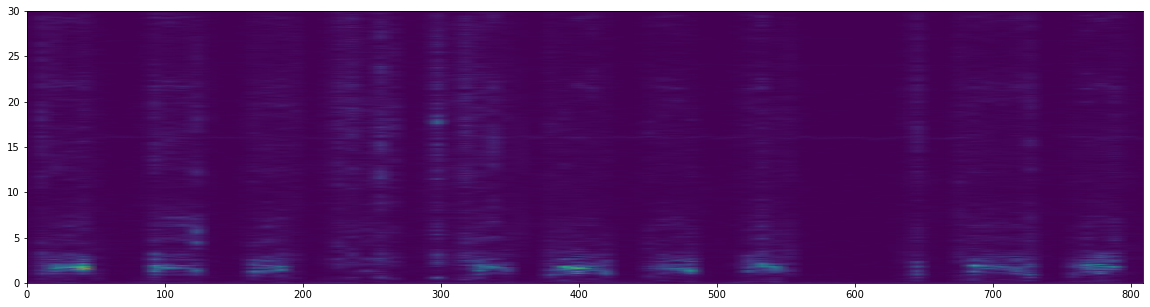

In [12]:
# FFT - Fast Fourier Transform
# Vlastnosti rôznych okien: 
W = 2048                 # Veľkosť okna
OVERLAP = 0              # Veľkosť prekrytia okien <0; W)
STEP = W - OVERLAP       # Posun okna na základe prekrytia
window = signal.tukey(W) # Window function. Pre boxcar: np.ones(W)
FS = 1/200               # Vzorkovacia frekvencia je 200 Hz

t = route.index
x = route['az_c'].values
t = np.array([t[i] for i in range(0,  len(x) - W, STEP)])
f_mag = np.asarray([
    # np.absolute(np.log(np.fft.fft(x[i:i+W] * window)[:W//2]))  # Logaritmický graf
    np.absolute(np.fft.fft(x[i:i+W] * window)[:W//2])            # Lineárny graf
    for i in range(0, len(x) - W, STEP)
]).T

f = np.fft.fftfreq(W, FS)[:W//2]
plt.pcolormesh(t, f, f_mag, shading='gouraud')
plt.ylim(0, 30)
plt.show()

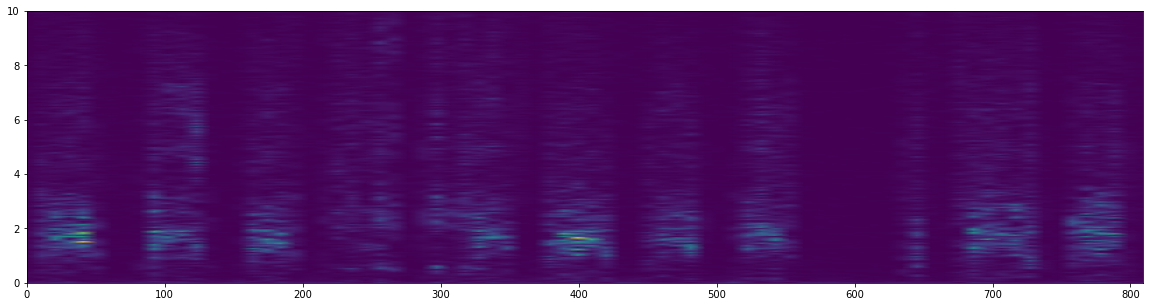

In [13]:
# DCT - Discrete Cosine Transform
W = 2048                 # Veľkosť okna
OVERLAP = 0              # Veľkosť prekrytia okien <0; W)
STEP = W - OVERLAP       # Posun okna na základe prekrytia
window = signal.tukey(W) # Window function. Pre boxcar: np.ones(W)
FS = 1/200               # Vzorkovacia frekvencia je 200 Hz

t = route.index
x = route['az_c'].values
t = np.array([t[i] for i in range(0,  len(x) - W, STEP)])
f_mag = np.asarray([
    np.abs(scipy.fft.dct(x[i:i+W], type=4))
    for i in range(0, len(x) - W, STEP)
]).T
f = np.linspace(0, 1/FS/2, W)

plt.pcolormesh(t, f, f_mag, shading='gouraud')
plt.ylim(0, 10)
plt.show()

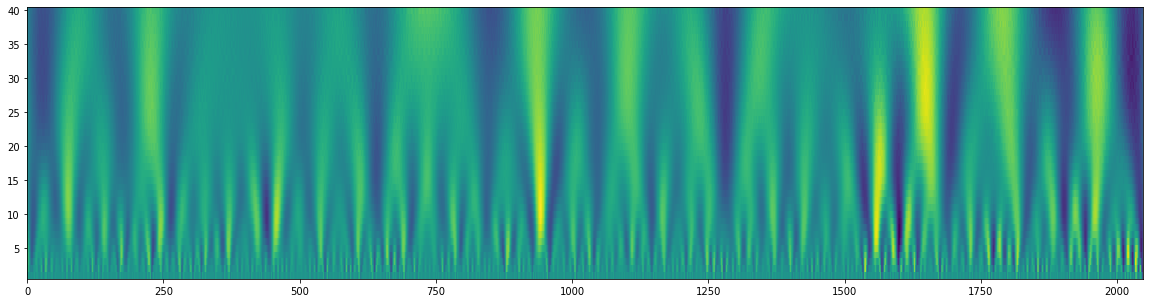

In [14]:
# CWT - Continous Wavelet Transform
sig = route['az_c'].values[:W]
t = np.arange(0, sig.size)
widths = np.arange(1, 41)
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')

plt.pcolormesh(t, widths, cwtmatr, shading='nearest')
plt.show()